# Calculs

## Constantes et Facteurs d'émission 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd


### Parametres Globaux

In [3]:
NB_ELEVES = 100
DUREE_MOOC = 10  # heures
MIX_ELEC_FR = 0.0519  # kgCO2e/kWh

#### Terminaux 

In [4]:
# Paramètres terminaux
df_source_fabrication = pd.read_csv('./csv/bdd_numérique_empreinte_Fabrication.csv', header=1)

def get_gwp_fabrication(nom_equipement_ademe):
    # On cherche la ligne qui contient le nom exact
    ligne = df_source_fabrication[df_source_fabrication['Données équipements'] == nom_equipement_ademe]
    
    if not ligne.empty:
        # On récupère la valeur et on convertit en float  
        valeur = ligne['PEF-GWP '].values[0]
        valeur = float(valeur.replace(",","."))
        return valeur
    else:
        print(f"Attention : '{nom_equipement_ademe}' introuvable dans le CSV")
        return 0.0
    
gwp_smartphone_fabrication = get_gwp_fabrication("Smartphone")
gwp_laptop_fabrication = get_gwp_fabrication("Ordinateur portable")
gwp_pc_tour_fabrication = get_gwp_fabrication("Ordinateur fixe (sans écran) personnel")
gwp_ecran_fabrication = get_gwp_fabrication("Ecran d'ordinateur")
gwp_pc_fixe_complet_fabrication = gwp_pc_tour_fabrication + gwp_ecran_fabrication
IMPACT_TOTAL_TERMINAUX = gwp_pc_fixe_complet_fabrication +gwp_laptop_fabrication+gwp_smartphone_fabrication

PARAMETRES_TERMINAUX = {
    'smartphone': {
        'ratio': 0.4,
        'usage_journalier':3,  # heures
        'duree_vie': 3,  # années
        'conso_elec': 3.9/365,  #kWh eh une année
        'impact_fab': gwp_smartphone_fabrication  # kgCO2e
    },
    'laptop': {
        'ratio': 0.4,
        'usage_journalier': 6,
        'duree_vie': 5,
        'conso_elec': 29.1/365,
        'impact_fab':gwp_laptop_fabrication
    },
    'desktop': {
        'ratio': 0.2,
        'usage_journalier': 3,
        'duree_vie': 5,
        'conso_elec': (100+70)/365,  # PC + Écran
        'impact_fab':gwp_pc_fixe_complet_fabrication  # PC + Écran
    }
}

 

#### Serveur

In [5]:
# Paramètres serveur
gwp_serveur_fabrication = get_gwp_fabrication("Serveur rack - moyen")
PARAMETRES_SERVEUR = {
    'allocation': 0.05,
    'pue': 1.6,
    'duree_vie': 5,  # années
    'puissance_annuelle': 1805,  # kWh
    'impact_fab': gwp_serveur_fabrication,  # kgCO2e
    'impact_fin_vie': 8.74  # kgCO2e
}

#### Réseau 

In [6]:
PARAMETRES_RESEAU = {
    'poids_video_go_h': 1,  # Go/h
    'conso_reseau_fixe': 0.05,  # kWh/Go
    'conso_reseau_mobile': 0.24,  # kWh/Go
    'ratio_fixe': 0.6,
    'ratio_mobile': 0.4,
    'impact_transfert_fixe_go': 0.00124,
    'impact_transfert_mobile_go': 0.0131
}
IMPACT_TRANSFERT_FIXE_GO= 0.00124 #kgCO2e
IMPACT_TRANSFERT_MOBIE_GO = 0.0131

## Calculs terminaux utilisateurs 

### Extraction des données 

In [7]:
import pandas as pd

print("--- Valeurs extraites du CSV (kg CO2e) ---")
print(f"Smartphone : {gwp_smartphone_fabrication}")
print(f"Laptop : {gwp_laptop_fabrication}")
print(f"PC Fixe (Complet) : {gwp_pc_fixe_complet_fabrication}")
print(f"Impact totale: {IMPACT_TOTAL_TERMINAUX}")
print(f"Serveur rack moyen : {gwp_serveur_fabrication}")


--- Valeurs extraites du CSV (kg CO2e) ---
Smartphone : 77.0
Laptop : 170.0
PC Fixe (Complet) : 323.6
Impact totale: 570.6
Serveur rack moyen : 698.0


### Amortissement de la fabrication 

$$ \text{Impact}_{\text{Total Fab Amorti}}=  \text{Impact}_{\text{Total Fab}} \times \frac{\text{Duree Mooc (10h)}}{\text{Duree de vie (annee)} \times 365 \times \text{Heure Usage jour}(h)} $$

Valeur de l'impact amorti de la fabrication

In [8]:
def calculer_impact_fabrication_terminal(impact_fab_total, duree_vie, 
                                         usage_journalier, duree_mooc):
    """
    Calcule l'impact de fabrication amorti d'un terminal.
    
    Args:
        impact_fab_total: Impact total de fabrication (kgCO2e)
        duree_vie: Durée de vie en années
        usage_journalier: Usage quotidien en heures
        duree_mooc: Durée du MOOC en heures
    
    Returns:
        Impact fabrication amorti (kgCO2e)
    """
    heures_vie_totale = duree_vie * 365 * usage_journalier
    return (impact_fab_total / heures_vie_totale) * duree_mooc


### Impact Usage 


étude de l'impact par étudiant en comparant chaque appareils $$ \text{Impact}_{\text{Usage}} = \text{Puissance appareil(kW)} \times 10 h \times \text{Mix Elec Français} $$ 

In [12]:
def calculer_impact_usage_terminal(conso_kwh, duree_mooc, mix_elec):
    """
    Calcule l'impact de l'usage électrique d'un terminal.
    
    Args:
        conso_kwh: Conso en (kWh) -
        duree_mooc: Durée en heures
        mix_elec: Mix électrique (kgCO2e/kWh)
    
    Returns:
        Impact usage (kgCO2e)
    """
    
    energie_kwh = conso_kwh  * duree_mooc
   
    return energie_kwh * mix_elec

### Impact total 

$$ I_{\text{Total Appareil}} = I_{\text{Fab}} + I_{\text{Usage}} $$

Somme pondéré pour déduire l'impact dans ce notre cas 
$$ (I_{\text{Total Tel}} \times 40) + (I_{\text{Total Laptop}} \times 40) + (I_{\text{Total FIxe}} \times 20) $$

In [26]:
def calculer_impact_terminal(type_terminal, params, nb_eleves, 
                             duree_mooc, mix_elec):
    """
    Calcule l'impact total d'un type de terminal.
    
    Args:
        type_terminal: Type ('smartphone', 'laptop', 'desktop')
        params: Dictionnaire des paramètres du terminal
        nb_eleves: Nombre d'élèves
        duree_mooc: Durée du MOOC
        mix_elec: Mix électrique
    
    Returns:
        Dict avec détails de l'impact
    """
    impact_fab = calculer_impact_fabrication_terminal(
        params['impact_fab'],
        params['duree_vie'],
        params['usage_journalier'],
        duree_mooc
    )
 
    
    impact_usage = calculer_impact_usage_terminal(
        params['conso_elec'],
        duree_mooc,
        mix_elec
    )
   
    
    impact_unitaire = impact_fab + impact_usage
    nb_utilisateurs =  params['ratio'] * nb_eleves
    impact_total = impact_unitaire * nb_utilisateurs
    
    return {
        'type': type_terminal,
        'impact_fab': impact_fab,
        'impact_usage': impact_usage,
        'impact_unitaire': impact_unitaire,
        'nb_utilisateurs': nb_utilisateurs,
        'impact_total': impact_total
    }

def calculer_impacts_terminaux(params_terminaux=PARAMETRES_TERMINAUX, 
                               nb_eleves=NB_ELEVES,
                               duree_mooc=DUREE_MOOC,
                               mix_elec=MIX_ELEC_FR):
    """
    Calcule les impacts de tous les terminaux.
    
    Returns:
        DataFrame avec tous les impacts, impact total
    """
    resultats = []
    
    for type_terminal, params in params_terminaux.items():
        impact = calculer_impact_terminal(
            type_terminal, params, nb_eleves, duree_mooc, mix_elec
        )
        resultats.append(impact)
    
    df = pd.DataFrame(resultats)
    impact_total = df['impact_total'].sum()
    
    return df, impact_total
print(calculer_impact_terminal('smartphone',PARAMETRES_TERMINAUX['smartphone'], NB_ELEVES,DUREE_MOOC,MIX_ELEC_FR))
print(calculer_impact_terminal('desktop',PARAMETRES_TERMINAUX['desktop'], NB_ELEVES,DUREE_MOOC,MIX_ELEC_FR))
print(calculer_impact_terminal('laptop',PARAMETRES_TERMINAUX['laptop'], NB_ELEVES,DUREE_MOOC,MIX_ELEC_FR))


{'type': 'smartphone', 'impact_fab': 0.2343987823439878, 'impact_usage': 0.0055454794520547945, 'impact_unitaire': 0.2399442617960426, 'nb_utilisateurs': 40.0, 'impact_total': 9.597770471841704}
{'type': 'desktop', 'impact_fab': 0.5910502283105024, 'impact_usage': 0.2417260273972603, 'impact_unitaire': 0.8327762557077627, 'nb_utilisateurs': 20.0, 'impact_total': 16.655525114155253}
{'type': 'laptop', 'impact_fab': 0.1552511415525114, 'impact_usage': 0.04137780821917808, 'impact_unitaire': 0.1966289497716895, 'nb_utilisateurs': 40.0, 'impact_total': 7.86515799086758}


## Calculs serveurs 

### Amortissement fabrication 

$$\text{Impact fabrication amorti} = \frac{\text{Impact Fab Total}}{\text{Duree de vie}} \times \text{Allocation}$$

In [27]:
def calculer_impact_fabrication_serveur(impact_fab_total, duree_vie, allocation):
    """
    Calcule l'impact de fabrication amorti du serveur.
    
    Args:
        impact_fab_total: Impact fabrication total (kgCO2e)
        duree_vie: Durée de vie (années)
        allocation: Coefficient d'allocation
    
    Returns:
        Impact fabrication amorti (kgCO2e)
    """
    return (impact_fab_total / duree_vie) * allocation

### Impact de l'usage annuel 

$$ \text{Energie Totale} = \text{Puissance} \times \text{PUE} \times \text{Allocation}$$
$$ \text{Impact} = \text{Energie Total} \times \text{Mix Elec Français}$$


In [28]:
def calculer_impact_usage_serveur(puissance_annuelle, pue, allocation, mix_elec):
    """
    Calcule l'impact de l'usage du serveur.
    
    Args:
        puissance_annuelle: Puissance annuelle (kWh)
        pue: Power Usage Effectiveness
        allocation: Coefficient d'allocation
        mix_elec: Mix électrique
    
    Returns:
        Impact usage (kgCO2e)
    """
    energie_allouee = puissance_annuelle * pue * allocation
    return energie_allouee * mix_elec



### Fin de vie serveur

$$\text{Impact Fin de vie} = \text{Impact Fin de vie total} \times \text{allocation} \times \frac{1}{\text{Duree de vie }} $$

In [29]:
def calculer_impact_fin_vie_serveur(impact_fin_vie_total, duree_vie, allocation):
    """
    Calcule l'impact de fin de vie amorti du serveur.
    
    Args:
        impact_fin_vie_total: Impact fin de vie total (kgCO2e)
        duree_vie: Durée de vie (années)
        allocation: Coefficient d'allocation
    
    Returns:
        Impact fin de vie amorti (kgCO2e)
    """
    return (impact_fin_vie_total * allocation) / duree_vie

def calculer_impacts_serveur(params_serveur=PARAMETRES_SERVEUR,
                             mix_elec=MIX_ELEC_FR):
    """
    Calcule tous les impacts du serveur.
    
    Returns:
        Dict avec détails des impacts
    """
    impact_fab = calculer_impact_fabrication_serveur(
        params_serveur['impact_fab'],
        params_serveur['duree_vie'],
        params_serveur['allocation']
    )
    
    impact_usage = calculer_impact_usage_serveur(
        params_serveur['puissance_annuelle'],
        params_serveur['pue'],
        params_serveur['allocation'],
        mix_elec
    )
    
    impact_fin_vie = calculer_impact_fin_vie_serveur(
        params_serveur['impact_fin_vie'],
        params_serveur['duree_vie'],
        params_serveur['allocation']
    )
    
    impact_total = impact_fab + impact_usage + impact_fin_vie
    
    return {
        'impact_fab': impact_fab,
        'impact_usage': impact_usage,
        'impact_fin_vie': impact_fin_vie,
        'impact_total': impact_total
    }
calculer_impacts_serveur()

{'impact_fab': 6.98,
 'impact_usage': 7.49436,
 'impact_fin_vie': 0.0874,
 'impact_total': 14.561760000000001}

## Calculs Réseau 

Evaluation du volume total de données 

$$ \text{VOL TOTAL} = 100 \text{Eleve} \times 10 h \times 1Go/h (débit 1080p) $$

In [30]:
def calculer_volume_donnees(nb_eleves, duree_mooc, debit_go_h):
    """
    Calcule le volume total de données transférées.
    
    Args:
        nb_eleves: Nombre d'élèves
        duree_mooc: Durée (heures)
        debit_go_h: Débit (Go/h)
    
    Returns:
        Volume total (Go)
    """
    return nb_eleves * duree_mooc * debit_go_h
calculer_volume_donnees(100,10,1)

1000

Consommation électrique réseau

$$\text{Conso Mobile} = \text{VOL TOTAL} \times 0.40 \times \text{Conso Réseau Mobile} $$
$$\text{Conso Fixe}  = \text{VOL TOTAL} \times 0.60 \times \text{Conso Réseau Fixe} $$


In [31]:
def calculer_impact_reseau(volume_total_go, ratio_mobile, conso_mobile_kwh_go,
                          conso_fixe_kwh_go, mix_elec):
    """
    Calcule l'impact du réseau.
    
    Args:
        volume_total_go: Volume total (Go)
        ratio_mobile: Part réseau mobile (0-1)
        conso_mobile_kwh_go: Consommation mobile (kWh/Go)
        conso_fixe_kwh_go: Consommation fixe (kWh/Go)
        mix_elec: Mix électrique
    
    Returns:
        Dict avec détails de l'impact
    """
    ratio_fixe = 1.0 - ratio_mobile
    
    conso_mobile_kwh = volume_total_go * ratio_mobile * conso_mobile_kwh_go
    conso_fixe_kwh = volume_total_go * ratio_fixe * conso_fixe_kwh_go
    conso_totale_kwh = conso_mobile_kwh + conso_fixe_kwh
    
    impact_reseau_kgco2e = conso_totale_kwh * mix_elec
    
    return {
        'volume_total_go': volume_total_go,
        'energie_mobile_kwh': conso_mobile_kwh,
        'energie_fixe_kwh': conso_fixe_kwh,
        'energie_totale_kwh': conso_totale_kwh,
        'impact_reseau_kgco2e': impact_reseau_kgco2e
    }

def calculer_impacts_reseau(params_reseau=PARAMETRES_RESEAU,
                           nb_eleves=NB_ELEVES,
                           duree_mooc=DUREE_MOOC,
                           mix_elec=MIX_ELEC_FR):
    """
    Calcule tous les impacts du réseau.
    
    Returns:
        Dict avec détails des impacts
    """
    volume = calculer_volume_donnees(
        nb_eleves,
        duree_mooc,
        params_reseau['poids_video_go_h']
    )
    
    return calculer_impact_reseau(
        volume,
        params_reseau['ratio_mobile'],
        params_reseau['conso_reseau_mobile'],
        params_reseau['conso_reseau_fixe'],
        mix_elec
    )
calculer_impacts_reseau()


{'volume_total_go': 1000,
 'energie_mobile_kwh': 96.0,
 'energie_fixe_kwh': 30.0,
 'energie_totale_kwh': 126.0,
 'impact_reseau_kgco2e': 6.5394000000000005}

Impact réseau 

$$\text{Impact Reseau} =  (\text{Conso Mobile} + \text{Conso Fixe}) \times \text{Mix Elec Français }  $$

In [32]:


def calcul_impact_reseau(vol_total_go, part_mobile, conso_mobile_kwh_go, conso_fixe_kwh_go):
    """
    Calcule la consommation électrique et l'impact carbone du réseau.
    
    Paramètres :
    - vol_total_go : Volume total de données (Go)
    - part_mobile : Pourcentage d'étudiants en 4G (ex: 0.40)
    - conso_mobile_kwh_go : Ratio énergétique 4G (kWh/Go)
    - conso_fixe_kwh_go : Ratio énergétique Wi-Fi/Fibre (kWh/Go)
    """
    
    # 1. Calcul de la part Fixe (le reste)
    part_fixe = 1.0 - part_mobile
    
    # 2. Calcul des consommations 
    # Conso = Volume * Part * Ratio
    conso_mobile_kwh = vol_total_go * part_mobile * conso_mobile_kwh_go
    conso_fixe_kwh = vol_total_go * part_fixe * conso_fixe_kwh_go
    
    # 3. Total Énergie Réseau
    conso_totale_kwh = conso_mobile_kwh + conso_fixe_kwh
    
    # 4. Impact Carbone
    impact_reseau_kgco2e = conso_totale_kwh * MIX_ELEC_FR
    
    return {
        "Energie_Mobile_kWh": conso_mobile_kwh,
        "Energie_Fixe_kWh": conso_fixe_kwh,
        "Energie_Totale_kWh": conso_totale_kwh,
        "Impact_Reseau_kgCO2e": impact_reseau_kgco2e
    }
calcul_impact_reseau(10, 0.1,100,100)


{'Energie_Mobile_kWh': 100.0,
 'Energie_Fixe_kWh': 900.0,
 'Energie_Totale_kWh': 1000.0,
 'Impact_Reseau_kgCO2e': 51.9}

### Impact totaux 

In [33]:
def calculer_acv_complete(params_terminaux=PARAMETRES_TERMINAUX,
                         params_serveur=PARAMETRES_SERVEUR,
                         params_reseau=PARAMETRES_RESEAU,
                         nb_eleves=NB_ELEVES,
                         duree_mooc=DUREE_MOOC,
                         mix_elec=MIX_ELEC_FR):
    """
    Effectue l'analyse complète du cycle de vie.
    
    Returns:
        Dict avec tous les résultats
    """
    # Calculs
    df_terminaux, impact_terminaux_total = calculer_impacts_terminaux(
        params_terminaux, nb_eleves, duree_mooc, mix_elec
    )
    
    impacts_serveur = calculer_impacts_serveur(params_serveur, mix_elec)
    
    impacts_reseau = calculer_impacts_reseau(
        params_reseau, nb_eleves, duree_mooc, mix_elec
    )
    
    # Impact total
    impact_total = (impact_terminaux_total + 
                   impacts_serveur['impact_total'] + 
                   impacts_reseau['impact_reseau_kgco2e'])
    
    return {
        'terminaux': {
            'dataframe': df_terminaux,
            'impact_total': impact_terminaux_total
        },
        'serveur': impacts_serveur,
        'reseau': impacts_reseau,
        'impact_total': impact_total
    }


## Affichage des résultat

In [34]:
def creer_graphique_repartition(resultats, filename='graphique_repartition.png'):
    """
    Crée un graphique en camembert de la répartition des impacts.
    
    Args:
        resultats: Résultats de l'ACV complète
        filename: Nom du fichier de sortie
    """
    labels = ['Terminaux', 'Serveur', 'Réseau']
    sizes = [
        resultats['terminaux']['impact_total'],
        resultats['serveur']['impact_total'],
        resultats['reseau']['impact_reseau_kgco2e']
    ]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        wedgeprops={'width': 0.5, 'edgecolor': 'w'}
    )
    
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.title("Répartition de l'Impact Carbone par Tiers", 
             fontsize=16, pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


In [35]:
def afficher_synthese(resultats):
    """
    Affiche un tableau de synthèse des résultats.
    
    Args:
        resultats: Résultats de l'ACV complète
    """
    print("=" * 70)
    print("SYNTHÈSE DE L'ANALYSE DU CYCLE DE VIE")
    print("=" * 70)
    print(f"\n{'Catégorie':<20} {'Impact (kgCO2e)':<20} {'Part (%)':<15}")
    print("-" * 70)
    
    total = resultats['impact_total']
    
    categories = [
        ('Terminaux', resultats['terminaux']['impact_total']),
        ('Serveur', resultats['serveur']['impact_total']),
        ('Réseau', resultats['reseau']['impact_reseau_kgco2e'])
    ]
    
    for nom, impact in categories:
        part = (impact / total) * 100
        print(f"{nom:<20} {impact:>18.2f} {part:>14.1f}%")
    
    print("-" * 70)
    print(f"{'TOTAL':<20} {total:>18.2f} {100:>14.1f}%")
    print("=" * 70)
    
    # Détails terminaux
    print("\nDétail des terminaux:")
    print(resultats['terminaux']['dataframe'].to_string(index=False))


## Analyse de sensibilité 

In [36]:
def analyse_sensibilite_mix_elec(mix_elec_values=[0.03, 0.05, 0.08, 0.10]):
    """
    Analyse la sensibilité de l'impact au mix électrique.
    
    Args:
        mix_elec_values: Liste des valeurs de mix électrique à tester
    
    Returns:
        DataFrame avec les résultats
    """
    resultats = []
    
    for mix in mix_elec_values:
        acv = calculer_acv_complete(mix_elec=mix)
        resultats.append({
            'mix_elec': mix,
            'impact_total': acv['impact_total'],
            'impact_terminaux': acv['terminaux']['impact_total'],
            'impact_serveur': acv['serveur']['impact_total'],
            'impact_reseau': acv['reseau']['impact_reseau_kgco2e']
        })
    
    return pd.DataFrame(resultats)


Calcul de l'ACV en cours...

SYNTHÈSE DE L'ANALYSE DU CYCLE DE VIE

Catégorie            Impact (kgCO2e)      Part (%)       
----------------------------------------------------------------------
Terminaux                         34.12           61.8%
Serveur                           14.56           26.4%
Réseau                             6.54           11.8%
----------------------------------------------------------------------
TOTAL                             55.22          100.0%

Détail des terminaux:
      type  impact_fab  impact_usage  impact_unitaire  nb_utilisateurs  impact_total
smartphone    0.234399      0.005545         0.239944             40.0      9.597770
    laptop    0.155251      0.041378         0.196629             40.0      7.865158
   desktop    0.591050      0.241726         0.832776             20.0     16.655525

Création du graphique...


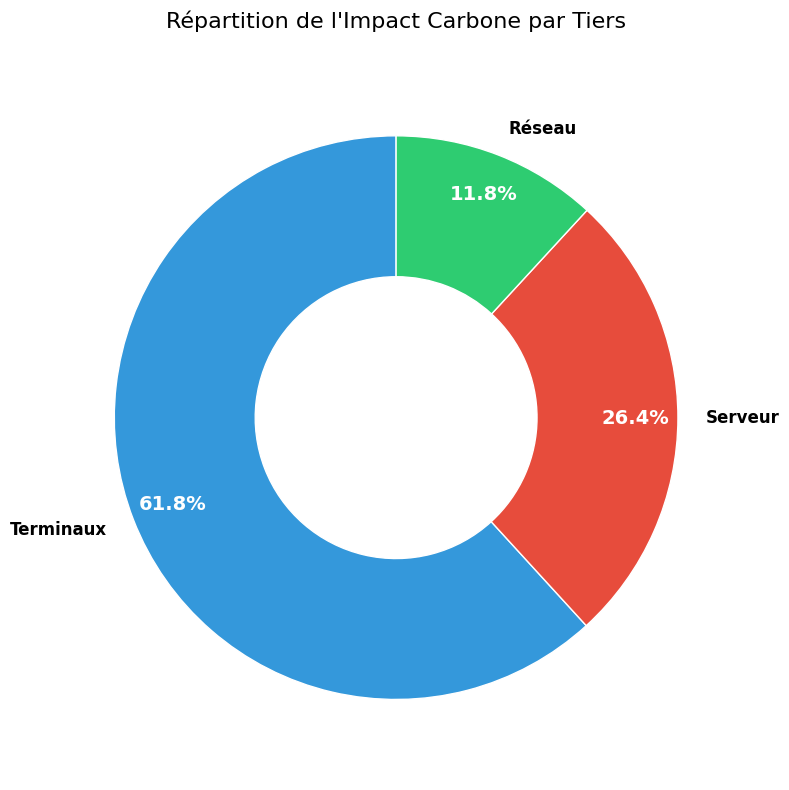


Analyse de sensibilité - Mix électrique:
 mix_elec  impact_total  impact_terminaux  impact_serveur  impact_reseau
     0.03     46.465854         31.286454         11.3994           3.78
     0.05     54.460155         33.872755         14.2874           6.30
     0.08     66.451607         37.752207         18.6194          10.08
     0.10     74.445908         40.338508         21.5074          12.60


In [37]:
if __name__ == "__main__":
    # Calcul de l'ACV complète
    print("Calcul de l'ACV en cours...\n")
    resultats = calculer_acv_complete()
    
    # Affichage des résultats
    afficher_synthese(resultats)
    
    # Création du graphique
    print("\nCréation du graphique...")
    creer_graphique_repartition(resultats)
    
    # Analyse de sensibilité
    print("\nAnalyse de sensibilité - Mix électrique:")
    df_sensibilite = analyse_sensibilite_mix_elec()
    print(df_sensibilite.to_string(index=False))